# Download, Read, Parse, and Preprocess Tiny ImageNet

In [1]:
import wget
import zipfile
from pathlib import Path
from PIL import Image

import autograd.numpy as np
from autograd import grad


In [5]:
filename = wget.download("http://cs231n.stanford.edu/tiny-imagenet-200.zip")

with zipfile.ZipFile(filename, 'r') as zip:
    zip.extractall('')

In [2]:
labelnames = []
label2index = {}
with open('tiny-imagenet-200/wnids.txt', 'r') as f:
    lines = f.readlines()
    labelnames = [line.strip() for line in lines]
    label2index = {label: i for i, label in enumerate(labelnames)}

In [10]:
paths = Path('tiny-imagenet-200/train/').glob('*/images/*.*')
def _readtinyimagenet(dirpath):
    Path(dirpath).glob('*/images/*.*')
    images = []
    labels = []
    for path in paths:
        labelname = path.parent.parent.stem
        label = label2index[labelname]
        with Image.open(path) as image:
            images.append(np.array(image.convert('RGB')))
            labels.append(label)
 
    return np.array(images), np.array(labels)

# X_train, Y_train = _readtinyimagenet('tiny-imagenet-200/train')
# X_val, Y_val = _readtinyimagenet('tiny-imagenet-200/val')
X_test, Y_test = _readtinyimagenet('tiny-imagenet-200/test')

In [22]:
height, width, channels = X_test.shape[1:]
print(height, width, channels)

64 64 3


In [12]:
N_train = 60000
N_val = 20000
X_train = X_test[:N_train]
Y_train = Y_test[:N_train]
X_val = X_test[N_train:N_train+N_val]
Y_val = Y_test[N_train:N_train+N_val]
X_test = X_test[N_train+N_val:]
Y_test = Y_test[N_train+N_val:]

In [23]:
X_train_flat = np.reshape(X_train, (-1, width*height*channels))
X_train_flat.shape

(60000, 12288)

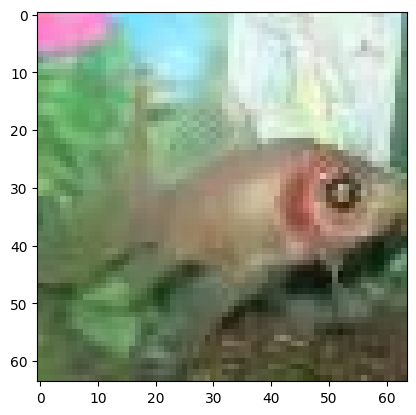

In [26]:
import matplotlib.pyplot as plt
plt.imshow(np.reshape(X_train[0], (height, width, channels)))

In [20]:
def onehot(y, k):
    probs = np.zeros((len(y),k))
    for i, p in enumerate(y):
        probs[i][p] = 1
    return probs

n_labels = len(labelnames)
Y_train_bin = onehot(Y_train, n_labels)
Y_val_bin = onehot(Y_val, n_labels)
Y_test_bin = onehot(Y_test, n_labels)

In [50]:
class NeuralNetwork:
    def __init__(self, input_dims, hidden_dims, output_dims):
        self.input_dims = input_dims
        self.hidden_dims = hidden_dims
        self.output_dims = output_dims
        
        self.W1 = np.zeros((self.hidden_dims, self.input_dims))
        self.b1 = np.zeros((self.hidden_dims,1))
        self.W2 = np.zeros((self.output_dims, self.hidden_dims))
        self.b2 = np.zeros((self.output_dims,1))

        self.init_parameters()

    def init_parameters(self):
        bound = np.sqrt(3.) / np.sqrt(self.input_dims)
        self.W1 = np.random.uniform(-bound, bound, size=(self.hidden_dims, self.input_dims))

        bound = 1. / np.sqrt(self.input_dims)
        self.b1 = np.random.uniform(-bound, bound, size=(self.hidden_dims,1))

        bound = np.sqrt(3.) / np.sqrt(self.hidden_dims)
        self.W2 = np.random.uniform(-bound, bound, size=(self.output_dims, self.hidden_dims))

        bound = 1. / np.sqrt(self.hidden_dims)
        self.b2 = np.random.uniform(-bound, bound, size=(self.output_dims,1))

    def forward_pass(self, X):
        self.Z1 = np.matmul(self.W1, X.T) + self.b1
        self.A1 = np.tanh(self.Z1)
        self.Z2 = np.matmul(self.W2, self.A1) + self.b2
        exp = np.exp(self.Z2).T
        self.out = exp / np.sum(exp, axis=-1, keepdims=True)
        return self.out

def loss_function(y_true, y_pred):
    ce = -np.sum(y_true*np.log(y_pred+1e-9), axis=-1) # cross-entropy
    return np.mean(ce)

In [51]:
model = NeuralNetwork(width*height*channels, 512, n_labels)
batch_size = 16
Y_pred = model.forward_pass(X_train_flat[:batch_size])
gradients = grad(loss_function(Y_train_bin[:batch_size], Y_pred))

(16, 200)
(16, 200)


In [56]:
gradients(X_train_flat[:batch_size])

TypeError: 'numpy.float64' object is not callable

In [54]:
gradients(model.W1)

TypeError: 'numpy.float64' object is not callable